In [ ]:
!pip install transformers datasets sentence-transformers faiss-cpu flask wandb accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `minor-project-final-project` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re

In [ ]:
import torch
import faiss
import gc
import wandb
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

# ==========================
# 1. Data Preparation Phase
# ==========================
wandb.init(project="rag-mistral7b", name="data_preprocessing")

# Load Alpaca dataset
data = load_dataset("tatsu-lab/alpaca", split="train")
data = data.select(range(5000))  # Use top 5000 samples

# Preprocess dataset
def format_text(example):
    return f"###Human: {example['instruction']} {example['input']} ###Assistant: {example['output']}"

formatted_data = [format_text(ex) for ex in data]

# Encode dataset using SentenceTransformer for retrieval
retriever = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = retriever.encode(formatted_data, convert_to_numpy=True)

# Create FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
faiss.write_index(index, "rag_index.faiss")
wandb.log({"faiss_index_size": len(formatted_data)})

# Free memory
del embeddings
gc.collect()
torch.cuda.empty_cache()

# ===========================
# 2. Model Training & Saving
# ===========================
wandb.init(project="rag-mistral7b", name="model_training")

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load Mistral 7B model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1",
    quantization_config=quantization_config, device_map="auto")

# Save the trained model locally
os.makedirs("mistral-rag", exist_ok=True)
model.save_pretrained("mistral-rag")
tokenizer.save_pretrained("mistral-rag")

print("✅ Training complete! Model & FAISS index saved.")
wandb.finish()


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

✅ Training complete! Model & FAISS index saved.


faiss_index_size,▁▁
faiss_index_size,5000


In [ ]:
import torch
import faiss
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer

# ==========================
# 1. Load Model & FAISS Index
# ==========================
print("🔄 Loading model and FAISS index...")

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("mistral-rag")
model = AutoModelForCausalLM.from_pretrained("mistral-rag", device_map="auto")

# Load FAISS index & Sentence Transformer
retriever = SentenceTransformer("all-MiniLM-L6-v2")
index = faiss.read_index("rag_index.faiss")

print("✅ Model and FAISS index loaded!")

# ==========================
# 2. Define RAG Pipeline
# ==========================
def retrieve_relevant_docs(query, k=3):
    query_embedding = retriever.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_docs = [formatted_data[i] for i in indices[0]]
    return retrieved_docs

def generate_response(query):
    # Retrieve relevant docs
    retrieved_docs = retrieve_relevant_docs(query)

    # Format input with retrieved context
    context = "\n".join(retrieved_docs)
    input_text = f"### Context:\n{context}\n### Question:\n{query}\n### Answer:"

    # Generate response
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=150)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    return response

# Test query
query = "What is reinforcement learning?"
print("🔍 Query:", query)
print("🤖 Response:", generate_response(query))


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


🔄 Loading model and FAISS index...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ Model and FAISS index loaded!
🔍 Query: What is reinforcement learning?
🤖 Response: ### Context:
###Human: Explain the concept of reinforcement learning in a simple and understandable way.  ###Assistant: Reinforcement learning is an area of machine learning that deals with learning how to make a sequence of decisions. In this kind of learning, an agent interacts with an environment in order to maximize its accumulated rewards. The agent makes choices based on its observations from the environment and then receives feedback in the form of rewards or punishments. With time, the agent learns to maximize its potential rewards by optimizing its choices.
###Human: Define the term 'machine learning'.  ###Assistant: Machine Learning is an application of artificial intelligence that allows systems to improve from experience without being explicitly programmed. It is a type of artificial intelligence that focuses on the development of computer programs that can access data, recognize patterns, 

In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()  # This will ask for your Hugging Face token


In [ ]:
from huggingface_hub import HfApi

api = HfApi()

# Create a new model repo on Hugging Face
repo_name = "mistral-rag-main"  # Your model repo name
user_name = "deep0210"  # Your Hugging Face username

api.create_repo(repo_id=f"{user_name}/{repo_name}", repo_type="model", exist_ok=True)

print(f"✅ Repository created: https://huggingface.co/{user_name}/{repo_name}")


✅ Repository created: https://huggingface.co/deep0210/mistral-rag-main


In [ ]:
api.upload_folder(
    folder_path="mistral-rag",  # Folder containing trained model & tokenizer
    repo_id=f"{user_name}/{repo_name}",
    repo_type="model"
)

# Push FAISS index
api.upload_file(
    path_or_fileobj="rag_index.faiss",
    path_in_repo="rag_index.faiss",
    repo_id=f"{user_name}/{repo_name}",
    repo_type="model"
)

print(f"✅ Model & FAISS index uploaded to: https://huggingface.co/{user_name}/{repo_name}")


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

rag_index.faiss:   0%|          | 0.00/7.68M [00:00<?, ?B/s]

✅ Model & FAISS index uploaded to: https://huggingface.co/deep0210/mistral-rag-main


In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=83737596ac6b19f5c99ea094541ab90f8013e86ffe5b10d590acaf97d1c95dc5
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  wa

Average BLEU Score (RAG Model): 0.3649450108776341
ROUGE-1: 0.5037383167558902
ROUGE-2: 0.48856856860010006
ROUGE-L: 0.5037383167558902


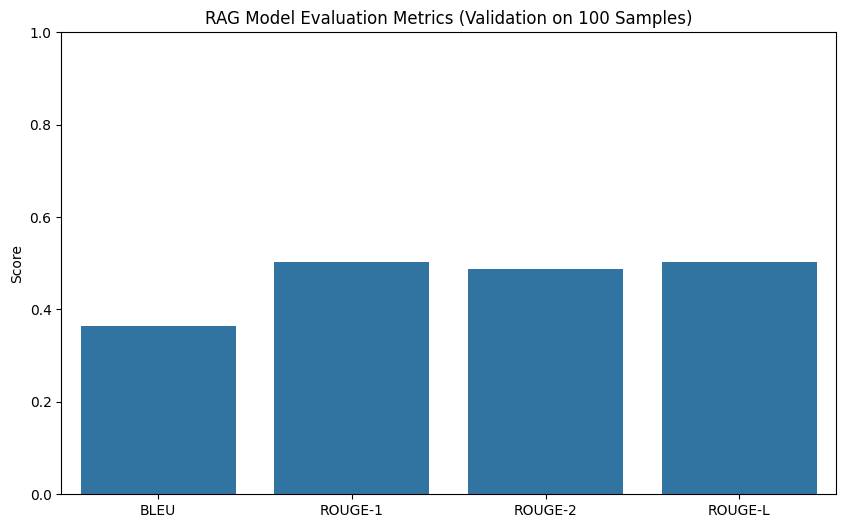

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from datasets import load_dataset, Dataset
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# Load Locally Saved RAG Model
# =======================
model_dir = "mistral-rag"  # Change this if your model is in a different folder
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForCausalLM.from_pretrained(model_dir, device_map="auto", torch_dtype=torch.float16)

# Move model to GPU (if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# =======================
# Load Validation Dataset
# =======================
data = load_dataset("tatsu-lab/alpaca", split="train")
data_df = data.to_pandas()
val_df = data_df[4000:4100]  # Use same 100 samples as before

# Format dataset
val_df.loc[:, "text"] = val_df[["input", "instruction", "output"]].apply(
    lambda x: "###Human: " + x["instruction"] + " " + x["input"] + " ###Assistant: " + x["output"], axis=1
)
val_data = Dataset.from_pandas(val_df)

# =======================
# Generate Predictions
# =======================
predictions = []
labels = []

for example in val_data:
    inputs = tokenizer(example["text"], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
        )
    predictions.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
    labels.append(example["output"])

# =======================
# Compute BLEU Scores
# =======================
bleu_scores = []
for pred, label in zip(predictions, labels):
    pred_tokens = pred.split()
    label_tokens = label.split()
    bleu_score = sentence_bleu([label_tokens], pred_tokens)
    bleu_scores.append(bleu_score)

avg_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU Score (RAG Model): {avg_bleu_score}")

# =======================
# Compute ROUGE Scores
# =======================
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(pred, label) for pred, label in zip(predictions, labels)]

# Average ROUGE scores
avg_rouge = {
    "rouge-1": np.mean([score["rouge1"].fmeasure for score in rouge_scores]),
    "rouge-2": np.mean([score["rouge2"].fmeasure for score in rouge_scores]),
    "rouge-L": np.mean([score["rougeL"].fmeasure for score in rouge_scores]),
}

# Print scores
print(f"ROUGE-1: {avg_rouge['rouge-1']}")
print(f"ROUGE-2: {avg_rouge['rouge-2']}")
print(f"ROUGE-L: {avg_rouge['rouge-L']}")

# =======================
# Plot Evaluation Metrics
# =======================
metrics = {
    "BLEU": avg_bleu_score,
    "ROUGE-1": avg_rouge["rouge-1"],  # Fixed
    "ROUGE-2": avg_rouge["rouge-2"],  # Fixed
    "ROUGE-L": avg_rouge["rouge-L"],  # Fixed
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title("RAG Model Evaluation Metrics (Validation on 100 Samples)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


In [ ]:
retriever = SentenceTransformer("all-MiniLM-L6-v2")
query_embedding = retriever.encode([query], convert_to_numpy=True)

index = faiss.read_index("rag_index.faiss")
# Example: retrieve top 3 documents
distances, indices = index.search(query_embedding, k=3)
retrieved_docs = [formatted_data[i] for i in indices[0]]

In [ ]:
from IPython.display import display, HTML

wrapped_text = """
<pre style="white-space: pre-wrap; word-wrap: break-word;">
Query: What is reinforcement learning?
Response:
### Context:
###Human: Explain the concept of reinforcement learning in a simple and understandable way.
###Assistant: Reinforcement learning is an area of machine learning that deals with learning how to make a sequence of decisions. In this kind of learning, an agent interacts with an environment in order to maximize its accumulated rewards. The agent makes choices based on its observations from the environment and then receives feedback in the form of rewards or punishments. With time, the agent learns to maximize its potential rewards by optimizing its choices.
###Human: Define the term 'machine learning'.
###Assistant: Machine Learning is an application of artificial intelligence that allows systems to improve from experience without being explicitly programmed. It is a type of artificial intelligence that focuses on the development of computer programs that can access data, recognize patterns, and learn from past experience to make decisions and predictions.
###Human: Find the definition of the phrase "machine learning"
###Assistant: Machine learning is a branch of artificial intelligence that focuses on the ability of systems to use data and patterns to improve their performance. It involves using algorithms to analyze data and then using the insights gained to build predictive models that enable the system to learn how to make decisions or predictions. It can be thought of as a form of artificial intelligence that allows computers to learn how to increase their accuracy in solving problems without being explicitly programmed.
### Question:
What is reinforcement learning?
### Answer:
Reinforcement learning is a type of machine learning that focuses on learning how to make a sequence of decisions. In this kind of learning, an agent interacts with an environment in order to maximize its accumulated rewards. The agent makes choices based on its observations from the environment and then receives feedback in the form of rewards or punishments. With time, the agent learns to maximize its potential rewards by optimizing its choices.
</pre>
"""

display(HTML(wrapped_text))
